# Going Downhill Fast: Achieving 29 Wh / mi
**Author:** Nick Gregorich **Date:** March, 2024

A couple days after [Lawrence Cayton's recent post on regenerative braking in EVs](https://www.linkedin.com/feed/update/urn:li:activity:7168281132390604800?updateEntityUrn=urn%3Ali%3Afs_feedUpdate%3A%28V2%2Curn%3Ali%3Aactivity%3A7168281132390604800%29), I found myself squinting in confusion at my Tesla Model Y navigation system

I was on the way back home to San Francisco from Kirkwood, Lake Tahoe. It was my first time driving an EV to Lake Tahoe with its high elevation and low temperatures. There are plenty of Tesla Super Chargers along the way so I wasn't anxious, but I was definitely confused

The navigation system was routing me 45 miles to a charger in Jackson, California and I would arrive with a battery state of charge (SoC) of 32%, plenty of margin! But my current SoC was ... 33%?

Well that's a concerning bug, I've really learned to trust the routing on road trips to ensure I have enough charge. **Spoiler:** it wasn't a bug

I have exported this trip's from the [Tessie app](https://www.tessie.com), let's take a look!

First we'll import my favorite analysis tools: `DuckDB`, `pandas`, and `Plotly`

In [1]:
import duckdb
import pandas as pd
import plotly.express as px

We'll store the filename as `filename` and set a constant to convert meters into feet. Strangely, elevation is the only data in [SI units](https://en.wikipedia.org/wiki/SI_base_unit), so we'll need a constant to convert meters to feet

We'll also store seconds in a minute and minutes in an hour

In [2]:
filename = "Tesla-2024-03-10 13-34-28-2024-03-10 14-25-11.csv"

feet_in_meter = 3.28084
s_in_min = 60
min_in_hour = 60

sample_interval_s = 15.0

Let's take a look at all of the column names and their types using `describe`

In [3]:
duckdb.query(
    f"""describe from '{filename}'"""
).to_df()

,column_name,column_type,null,key,default,extra
0,Timestamp (PDT),TIMESTAMP,YES,None,None,None
1,State,VARCHAR,YES,None,None,None
2,Charging State,VARCHAR,YES,None,None,None
3,Shift State,VARCHAR,YES,None,None,None
4,Battery Level (%),BIGINT,YES,None,None,None
5,Usable Battery Level (%),BIGINT,YES,None,None,None
6,Battery Range (mi),DOUBLE,YES,None,None,None
7,Est. Battery Range (mi),VARCHAR,YES,None,None,None
8,Ideal Battery Range (mi),DOUBLE,YES,None,None,None
9,Latitude,DOUBLE,YES,None,None,None


When we query a .csv or .parquet file, it may not have the nicest column names to type over and over again

Let's create a [SQL view](https://en.wikipedia.org/wiki/View_(SQL)) to make our lives easier when referencing the .csv and its columns

In [4]:
duckdb.query(
    f"""create or replace view data_v as
                 select "Timestamp (PDT)" as ts,
                 State as state,
                 "Charging State" as charging_state,
                 "Shift State" as shift_state,
                 "Battery Level (%)" as battery_level,
                 "Usable Battery Level (%)" as usable_battery_level,
                 "Battery Range (mi)" as battery_range,
                 "Est. Battery Range (mi)" as estimated_battery_range,
                 "Ideal Battery Range (mi)" as ideal_battery_range,
                 "Latitude" as latitude,
                 "Longitude" as longitude,
                 "Elevation (m)" as elevation,
                 "Speed (mph)" as speed,
                 "Power (kW)" as power,
                 "Odometer (mi)" as odometer,
                 "Charge Rate (mph)" as charge_rate,
                 "Current (A)" as current,
                 "Charger Power (kW)" as charger_power,
                 "Charger Voltage (V)" as charger_voltage,
                 "Charger Phases" as charger_phases,
                 "Energy Added (kWh)" as energy_added,
                 "Rated Range Added (mi)" as rated_range_added,
                 "Ideal Range Added (mi)" as ideal_range_added,
                 "Climate" as climate,
                 "Battery Heater" as battery_heater,
                 "Inside Temp (°F)" as inside_temperature,
                 "Outside Temp (°F)" as outside_temperature,
                 "Locked" as locked,
                 "Sentry Mode" as sentry_mode
                 from '{filename}'"""
)

We can preview the first 5 rows of the view

In [5]:
df = duckdb.query(f"select * from data_v").to_df()
df.head()

,ts,state,charging_state,shift_state,battery_level,usable_battery_level,battery_range,estimated_battery_range,ideal_battery_range,latitude,...,charger_phases,energy_added,rated_range_added,ideal_range_added,climate,battery_heater,inside_temperature,outside_temperature,locked,sentry_mode
0,2024-03-10 13:34:28,online,Disconnected,D,34,34,97.13,None,97.13,38.627872,...,None,61.26,231,231,1,0,65,37,1,0
1,2024-03-10 13:34:41,online,Disconnected,D,34,34,97.13,None,97.13,38.628258,...,None,61.26,231,231,1,0,65,37,1,0
2,2024-03-10 13:40:55,online,Disconnected,D,32,32,92.70,None,92.70,38.570797,...,None,61.26,231,231,1,0,66,37,1,0
3,2024-03-10 13:41:18,online,Disconnected,D,32,32,92.70,None,92.70,38.567470,...,None,61.26,231,231,1,0,66,37,1,0
4,2024-03-10 13:41:25,online,Disconnected,D,32,32,92.70,None,92.70,38.564610,...,None,61.26,231,231,1,0,66,37,1,0


We'll [union](https://en.wikipedia.org/wiki/Set_operations_(SQL)) a number of queries together to make column / tidy oriented data. We'll add a column called polarity that will read `discharge` if the battery is discharging (and the vehicle is likely accelerating) and `charge` if the battery is charging (regenerative braking)

To support our tidy data, we'll have a variable column called `sensor` and a value column called `reading`. We'll include the following sensors:

1. `Trip (mi)`
    1. How many miles into the trip we are, starting at 0
    2. This is derived as: `odometer - min(odometer)`
2. `Speed (mph)`
   1. Speed of travel
3. `Range (mi)`
    1. How many miles the vehicle estimates we can travel based on the battery SoC (and other factors)
    2. `battery_level` is an integer [0% - 100%] so it is somewhat coarse
    3. `battery_range` is also coarse, but better than `battery_level`
4. `Power (kW)`
    1. Positive power indicates battery discharge (generally acceleration)
    2. Negative power indicates battery charge (regenerative braking)
    3. Unclear if this is an instantaneous value at the arbitrary point in time or if it includes any smoothing / aggregation
    4. I suspect it is an instantaneous value
5. `Elevation (ft)`
    1. Elevation, converted from meters to feet 

We'll preview the first 5 rows

In [6]:
df = duckdb.query(
    f"""select ts,
               case when power >= 0 then 'discharge'
               else 'charge' end as polarity,
               'Trip (mi)' as sensor,
               odometer - (select min(odometer) from data_v) as reading
               from data_v
        union
        select ts,
               case when power >= 0 then 'discharge'
               else 'charge' end as polarity,
               'Speed (mph)' as sensor,
               speed as reading
               from data_v
        union
               select ts,
               case when power >= 0 then 'discharge'
               else 'charge' end as polarity,
               'Range (mi)' as sensor,
               battery_range as reading
               from data_v
        union
        select ts,
               case when power >= 0 then 'discharge'
               else 'charge' end as polarity,
               'Power (kW)' as sensor,
               power as reading
               from data_v
        union
        select ts,
               case when power >= 0 then 'discharge'
               else 'charge' end as polarity,
               'Elevation (ft)' as sensor,
               {feet_in_meter} * elevation as reading
               from data_v

        order by ts
               """
).to_df()

df.head()

,ts,polarity,sensor,reading
0,2024-03-10 13:34:28,discharge,Elevation (ft),7440.94512
1,2024-03-10 13:34:28,discharge,Range (mi),97.13000
2,2024-03-10 13:34:28,discharge,Speed (mph),63.00000
3,2024-03-10 13:34:28,discharge,Power (kW),30.00000
4,2024-03-10 13:34:28,discharge,Trip (mi),0.00000


Now we'll make the plot:

1. We create a Plotly Express scatter `fig`
2. We give it our `df`
3. We want to plot time `ts` on the x-axis
4. We plot our tidy `reading` on the y-axis
5. We plot each `sensor` individually using `facet_row`
   1. Trip (mi)
   2. Speed (mph)
   3. Range (mi)
   4. Power (kW)
   5. Elevation (ft)
6. We color code each point
   1. Red for positive battery discharge power
   2. Blue for negative battery charge power

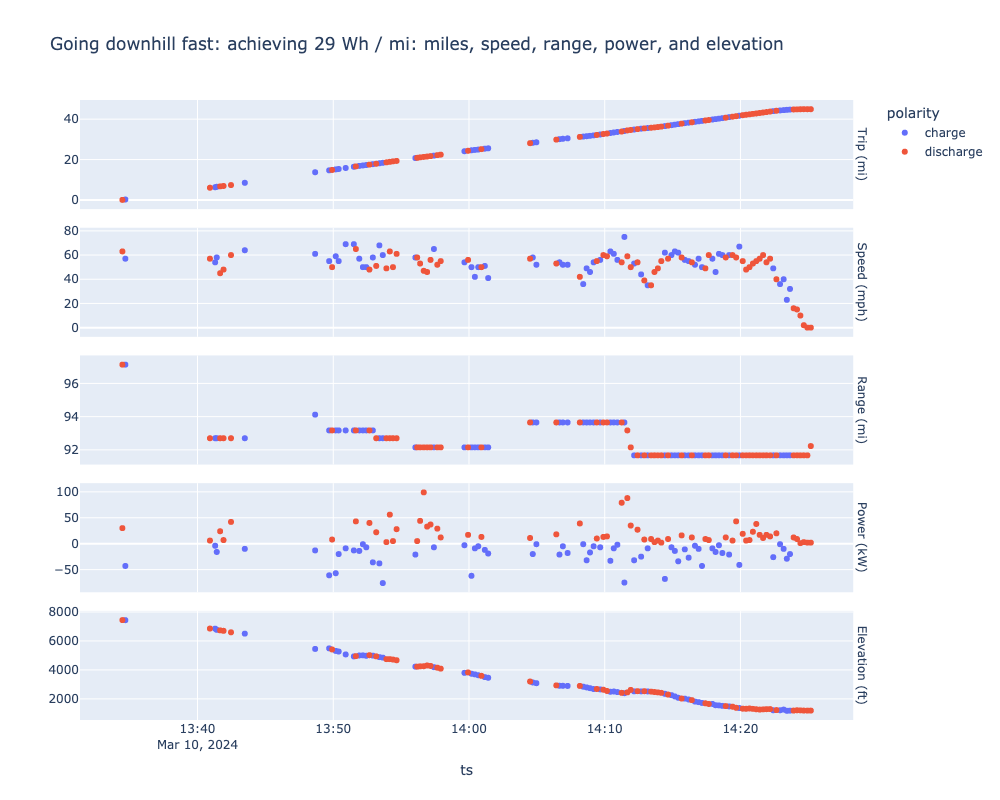

In [7]:
fig = px.scatter(
    df,
    x="ts",
    y="reading",
    facet_row="sensor",
    color="polarity",
    title="Going downhill fast: achieving 29 Wh / mi: miles, speed, range, power, and elevation",
    height=800,
    width=1000,
    category_orders={
        "sensor": ["Trip (mi)", "Speed (mph)", "Range (mi)", "Power (kW)", "Elevation (ft)"],
        "polarity": ["charge", "discharge"]
    },
)
fig.update_yaxes(matches=None, title="")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
# uncomment this line to export HTML
# fig.write_html("kirkwood_to_jackson.html")
# uncomment this line to export png
# fig.write_image('kirkwood_to_jackson.png')
fig.show("png")

This is my first time looking at the Tessie app data in detail, what can we see?

1. There are gaps up to 5 minutes in the data, presumably from poor cellular service in the mountains
2. The maximum sample rate looks something like once every 15 seconds
   1. A little slower than we'd like
   2. But infinitely faster than my old ICE car's sample rate of 0 samples per second
3. Trip (mi) increases very linearly until the last 5% where the slope decreases significantly
   1. This suggests a fairly constant speed for the majority of the trip
   2. Followed by a short distance at a lower speed
4. Speed confirms a somewhat flat 90% of the trip averaging around 55 mph
   1. Confirmed that last 10% of the trip has a slowing trend
5. Range is our best proxy of energy in the battery
   1. Recall, battery_level is integer [0 - 100]
   2. The very beginning of the trip has a range of 97.13 miles
   3. This goes down to 92.7 miles after the first 5 minute gap
   4. The range bounces up twice
      1. Once peaking briefly at 94.12 miles
      2. Then sustained at 93.65 miles
   5. The fairly constant value (range less than 6 miles over a 45 mile trip) supports the significant regenerative braking delivering extremely high efficiency
6. Power polarity is spread fairly evenly in time and amplitude over the trip
   1. This indicates similar discharge / charge and acceleration / regenerative braking times and rates
   2. Discharge and charge have different maximum amplitudes
      1. Discharge peaks at 99 kW
      2. Charge peaks at -67 kW
      3. I have not read on whether the Model Y can discharge and charge at the same rates
7. Elevation starts fairly linear then tapers off
   1. It seems you can see this trend in speed

Since we have large gaps in our data and a relatively slow sample rate, I opted to use proxies like `battery_range` to analyze this trip. But what does it look like if we use the power data to estimate energy?

If we use the strict time interval between samples to calculate energy from power, we are likely to introduce significant error from the gaps in time. If we are at a very large or very small value and then have an intermittent connection, we assume that very large / small value for the entire duration of our gap, resulting in error

We could be a little more sophisticated and use [Simpson's Rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) or [the trapezoid rule](https://en.wikipedia.org/wiki/Trapezoidal_rule), but instead I chose to simply use each power number for 15 seconds in order to calculate energy

So we'll take power, multiply by 15 seconds, then divide by 60 seconds in a minute and 60 minutes in an hour. This will give us something that looks like kWh. We'll preview the first 5 rows and then look at basic stats

In [8]:
df = duckdb.query(
    f"""       select ts,
               case when power >= 0 then 'discharge'
               else 'charge' end as polarity,
               power,
               power * {sample_interval_s} / {s_in_min} / {min_in_hour} as energy
               from data_v
        order by ts
               """
).to_df()

df.head()

,ts,polarity,power,energy
0,2024-03-10 13:34:28,discharge,30,0.125000
1,2024-03-10 13:34:41,charge,-43,-0.179167
2,2024-03-10 13:40:55,discharge,6,0.025000
3,2024-03-10 13:41:18,charge,-4,-0.016667
4,2024-03-10 13:41:25,charge,-16,-0.066667


In [9]:
print(f"energy max: {df.energy.max():.3f}")
print(f"energy min: {df.energy.min():.3f}")
print(f"energy mean: {df.energy.mean():.3f}")
print(f"energy median: {df.energy.median():.3f}")

energy max: 0.412
energy min: -0.317
energy mean: -0.000
energy median: 0.000


The maximum energy discharged from the battery is estimated to be 0.412 kWh (over 15 seconds). The maximum energy charged to the battery is estimated to be 0.317 kWh (over 15 seconds)

The mean and median are both 0! This is somewhat unexpected as the Tessie app listed that this trip took 1.3 kWh. The gaps in our data and / or the low sample rate caused our basic model to under estimate the energy it took to drive from Kirkwood to Jackson

Either way, that was fun. We have data that supports traveling 44.9 mi using just 1.3 kWh, for an amazing 29 Wh / mi! I wish I could get that mileage all the time

It wasn't a bug after all, it was a feature (of EVs and gravity)